The outlier detection algorithm based on KMeans clustering requires validation that will determine the reconstruction error threshold. The threshold is the cut off value, which dictates whether a tested light curve is dissimilar enough to the training to the training light curves to be labeled as an outlier.
In order to establish this value for the light curves of the rho class (the heartbeat), KMeans clustering was performed on nine training rho observations. Light curves of different classes were then reconstructed using the centroids of those clusters.

Minimised cells include the code for 1.preparing light curve data and splitting into sets, 2.segmenting light curves of the rho class from the training set and fitting a model to them, 3.reconstructing a light curve of kappa class from the validation set

In [63]:
# my horrible spaghetti that imports and prepares the data, and then splits it into training, validation and test sets 

import importlib
import os
import fnmatch
import numpy as np
from sklearn.model_selection import train_test_split
from collections import Counter
import csv
from sklearn import tree
import sys
sys.stdout.flush()
import math
import matplotlib.pyplot as plt
from matplotlib.table import Table
import segment_cluster as sc
import importlib
importlib.reload(sc)
from sklearn.cluster import KMeans

cwd = os.getcwd()
if cwd.split("/")[1] == "home":
    data_path="/home/jkok1g14/Documents/GRS1915+105/data/Std1_PCU2"
elif cwd.split("/")[1] == "export":
    data_path="/export/data/jakubok/GRS1915+105/Std1_PCU2"
else:
    print("Set the path for data directory!", Flush=True)

clean_belloni = open('1915Belloniclass_updated.dat')
lines = clean_belloni.readlines()
states = lines[0].split()
belloni_clean = {}
for h,l in zip(states, lines[1:]):
    belloni_clean[h] = l.split()
    #state: obsID1, obsID2...
ob_state = {}
for state, obs in belloni_clean.items():
    if state == "chi1" or state == "chi2" or state == "chi3" or state == "chi4": state = "chi"
    for ob in obs:
        ob_state[ob] = state

available = []
pool=[]

#/home/jkok1g14/Documents/GRS1915+105/data
#/export/data/jakubok/GRS1915+105/Std1_PCU2
for root, dirnames, filenames in os.walk(data_path):
    for filename in fnmatch.filter(filenames, "*_std1_lc.txt"):
        available.append(filename)
for ob, state in ob_state.items():
    if ob+"_std1_lc.txt" in available:
        pool.append(ob)  

#create a list of arrays with time and counts for the set of Belloni classified observations
lc_dirs=[]
lcs=[]
ids=[]
for root, dirnames, filenames in os.walk(data_path):    
    for filename in fnmatch.filter(filenames, "*_std1_lc.txt"):
        if filename.split("_")[0] in pool:
            lc_dirs.append(os.path.join(root, filename))

            
#make 2D arrays for light curves, with columns of counts and time values
for lc in lc_dirs:
    ids.append(lc.split("/")[-1].split("_")[0])
    f=np.loadtxt(lc)
    f=np.transpose(f)#,axis=1)
    f=f[0:2]
    ###1s average and time check to eliminate points outside of GTIs
    f8t = np.mean(f[0][:(len(f[0])//8)*8].reshape(-1, 8), axis=1)
    f8c = np.mean(f[1][:(len(f[1])//8)*8].reshape(-1, 8), axis=1)
    #f8c=f8c-np.mean(f8c)#normalisation/mean centering/whatever you desire most
    rm_points = []
    skip=False
    for i in range(len(f8t)-1):
        if skip==True:
            skip=False
            continue
        delta = f8t[i+1]-f8t[i]
        if delta > 1.0:
            rm_points.append(i+1)
            skip=True
            
####### normalise the count rates! think about the effect of 0-1 normalisation on the distance calculation
####### due to the energy integration in Std1 diefferences between different epochs shouldn't matter; there would be very few photons found at the extremes of the range            
    times=np.delete(f8t,rm_points)
    counts=np.delete(f8c,rm_points)
    lcs.append(np.stack((times,counts)))
#a list of light curve 2D arrays

lc_classes=[]
for i in ids:
    lc_classes.append(ob_state[i])

drop_classes=[]
for clas, no in Counter(lc_classes).items():
    if no<7:
        drop_classes.append(clas)

lcs_abu = []
classes_abu = []
ids_abu = []
for n, lc in enumerate(lc_classes):
    if lc not in drop_classes:
        classes_abu.append(lc)
        lcs_abu.append(lcs[n])
        ids_abu.append(ids[n])  
#a list of light curve 2D arrays of classes with at least 7 light curves

all_counts=[]
for lc in lcs_abu:
    all_counts.append(lc[1])
all_counts_ar=np.concatenate(all_counts, axis=0)
armean=np.mean(all_counts_ar)
arstd=np.std(all_counts_ar)
armedian=np.median(all_counts_ar)
armin=np.min(all_counts_ar)
sigma4=armean+4*arstd-armin

#sigma4 is going to be the assumed maximum count rate that will be used to normalise the data

lcs_abu_std=[]
for lc in lcs_abu:
    lc[1]=(lc[1]-armean)/arstd
    lcs_abu_std.append(lc)
    
# data is standardised, x_i_stand = (x_i - x_mean)/x_std

x_train, x_test, y_train, y_test, id_train, id_test = train_test_split(lcs_abu_std, classes_abu, ids_abu, test_size=0.5, random_state=0, stratify=classes_abu)
x_valid, x_test, y_valid, y_test, id_valid, id_test = train_test_split(x_test, y_test, id_test, test_size=0.5, random_state=0, stratify=y_test)

In [64]:
##train the model
model_class="rho"

n_clusters=100
length=50
time_stamps=False
offset=True
training_ys=np.where(np.array(y_train)=='{}'.format(model_class))[0]
all_train_segments=[]
for ts_i in training_ys:
    ts=x_train[ts_i]
    train_segments=sc.segmentation(ts, length, 2, time_stamps=time_stamps)
    c_train_segments=sc.center_offset(train_segments, ts, offset=offset, time_stamps=time_stamps)
    all_train_segments.append(c_train_segments)
all_train_segments=np.vstack(all_train_segments)
if proportion > len(all_train_segments): proportion = len(all_train_segments)
cluster=KMeans(n_clusters=n_clusters, random_state=0)
cluster.fit(all_train_segments)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=100, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

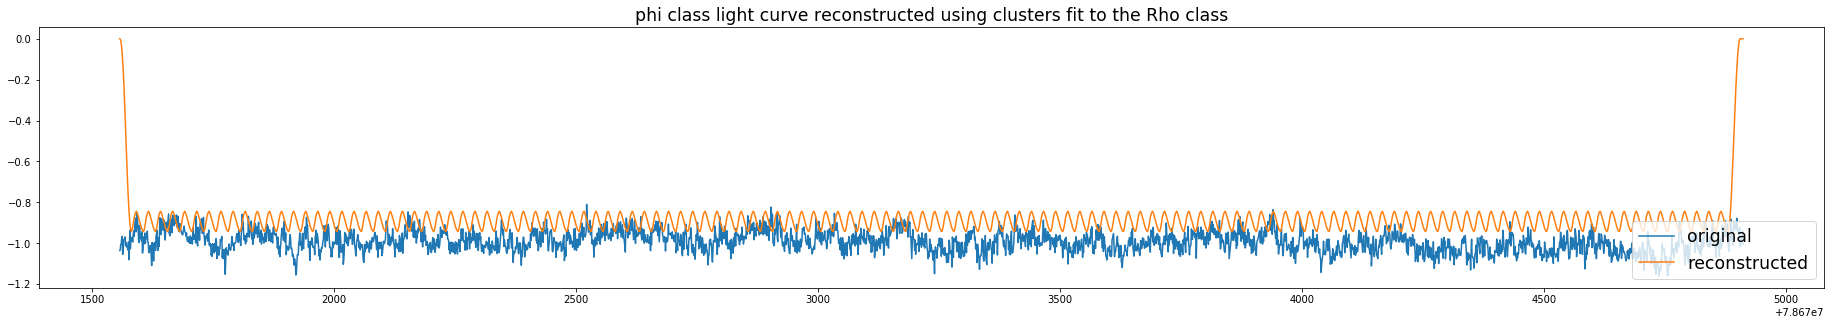

Root mean squared error of reconstruction: 0.11632730672570023


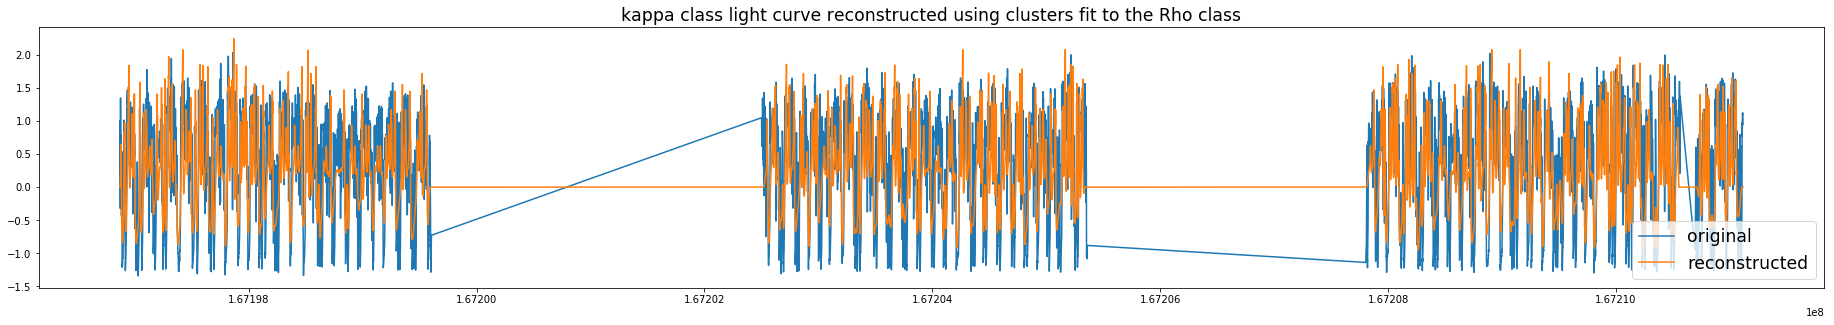

Root mean squared error of reconstruction: 0.5967231424345106


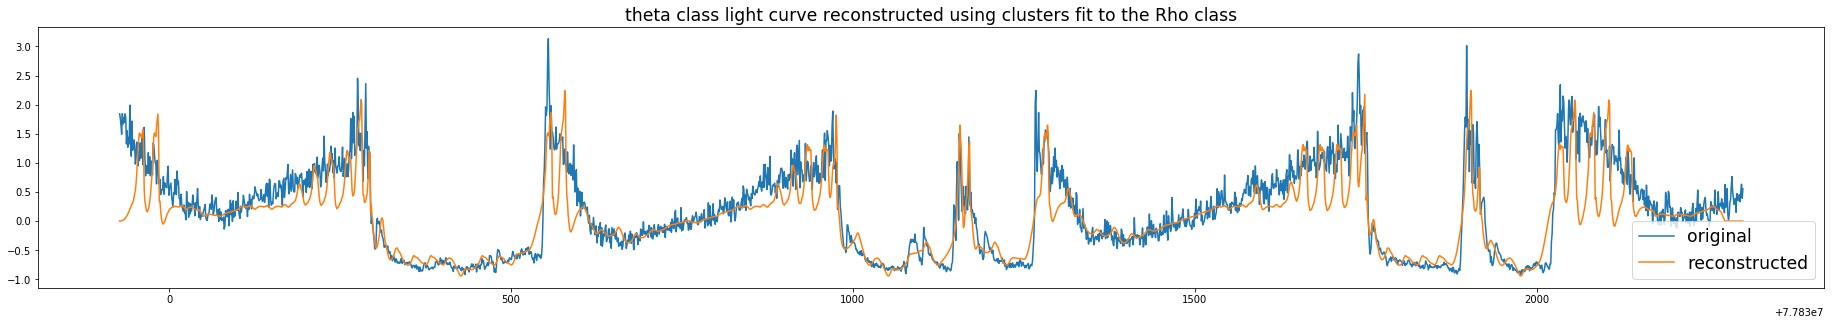

Root mean squared error of reconstruction: 0.39243494768604226


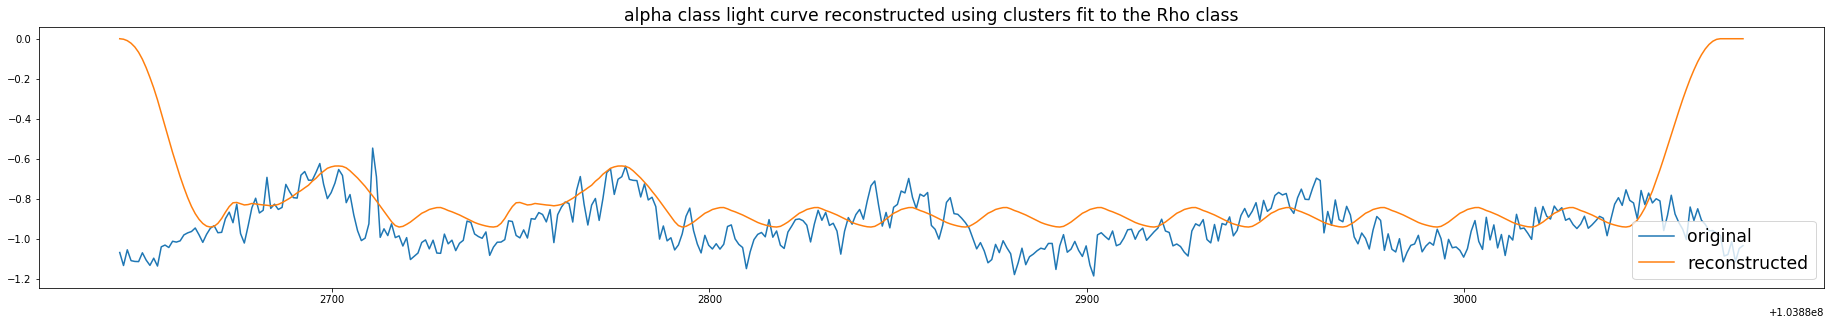

Root mean squared error of reconstruction: 0.12349487718132242


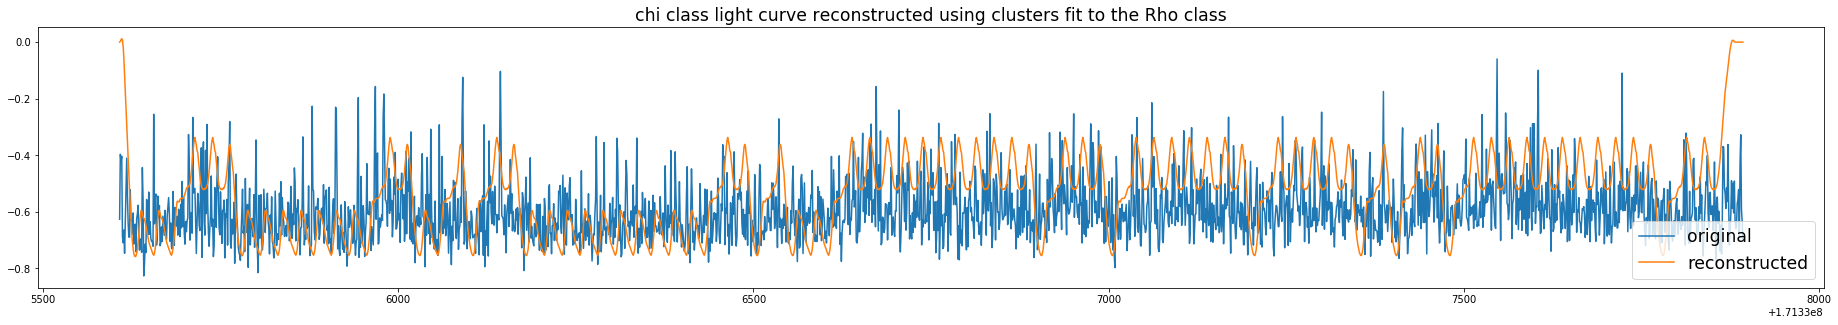

Root mean squared error of reconstruction: 0.15229662259641183


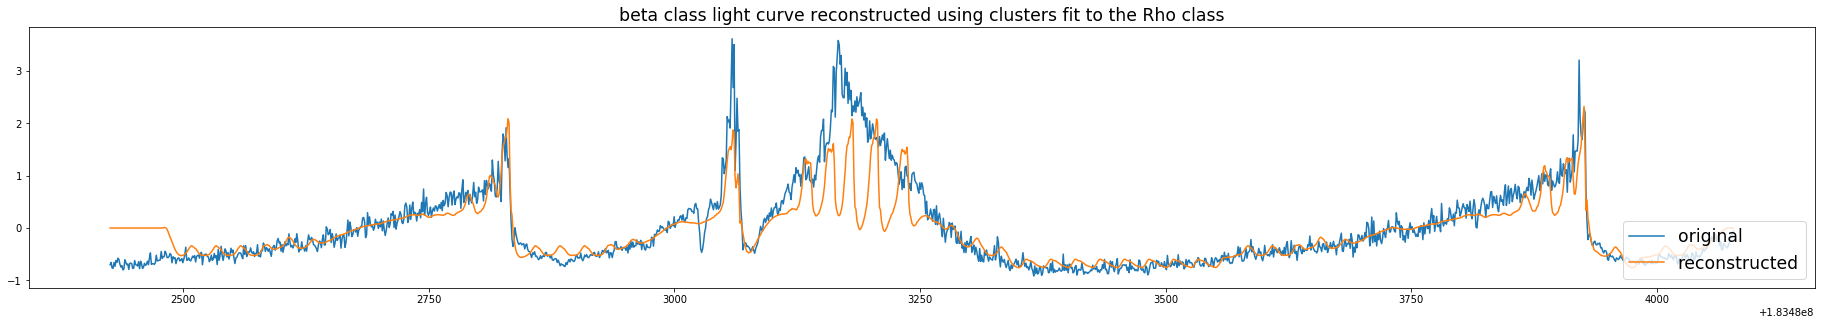

Root mean squared error of reconstruction: 0.4254986940845377


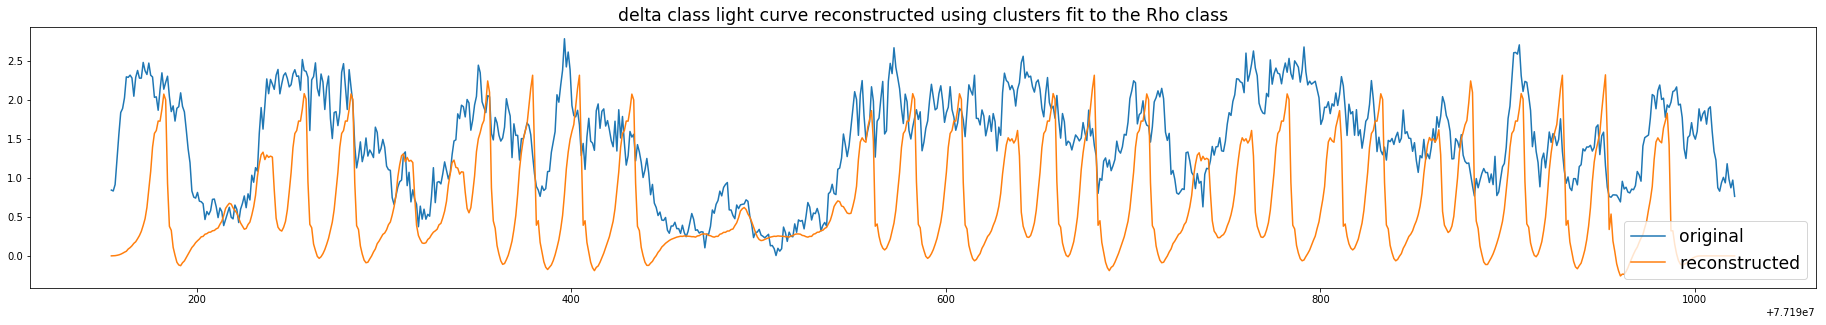

Root mean squared error of reconstruction: 1.0523647041530841


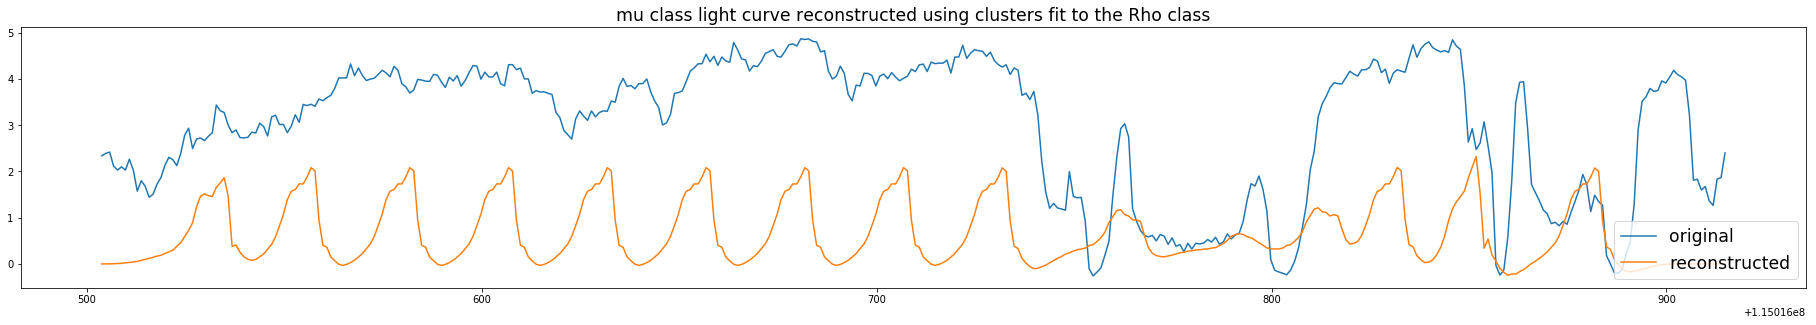

Root mean squared error of reconstruction: 2.920568735146281


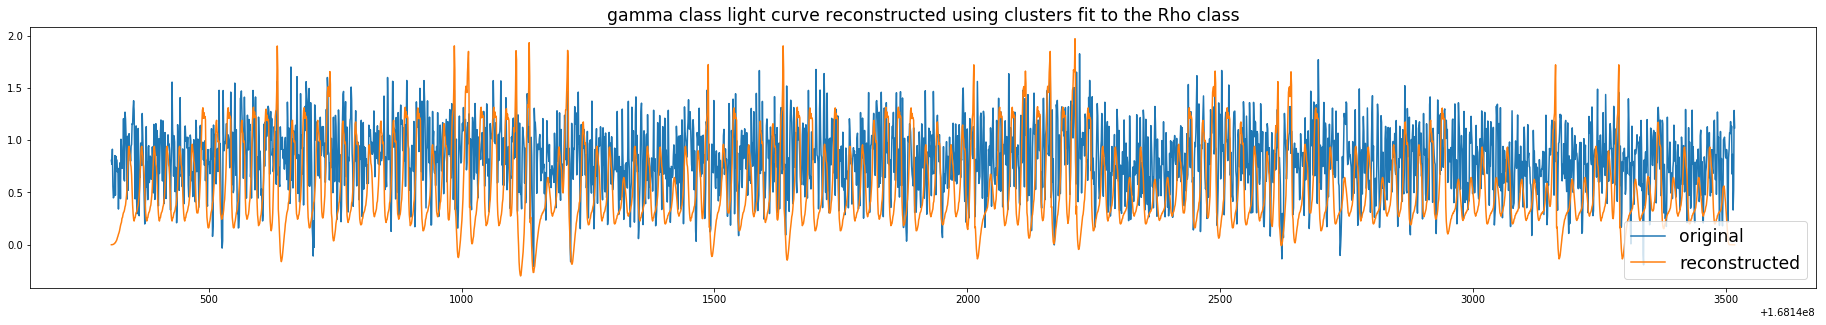

Root mean squared error of reconstruction: 0.5061862996963834


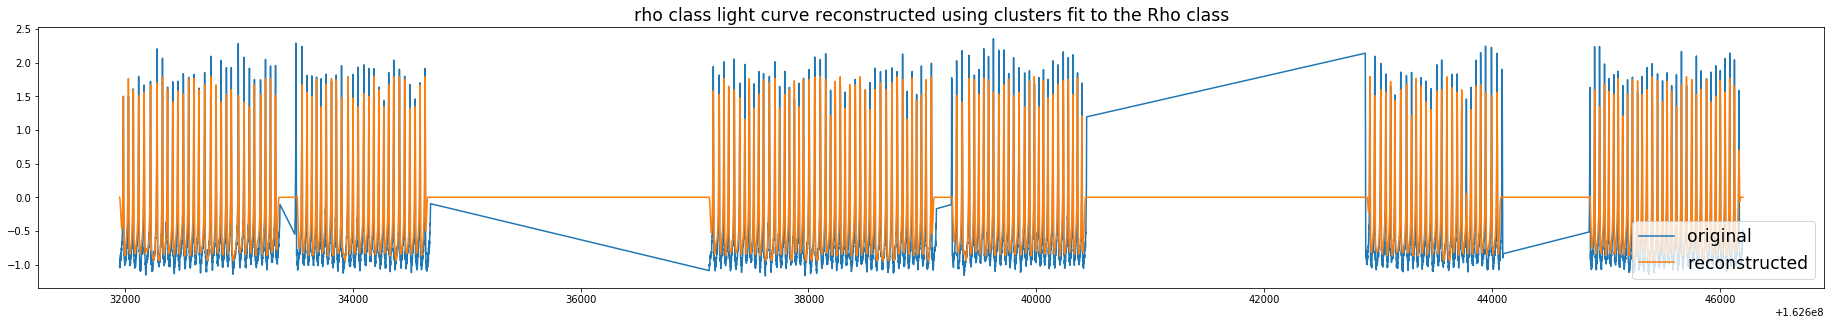

Root mean squared error of reconstruction: 0.27926110533277604


In [71]:
# reconstruct an observation of each tested class. 
importlib.reload(sc)
classes=list(set(y_valid))
for class_current in classes:
    ts_id=np.where(np.array(y_valid)==class_current)[0][0]
    time_stamps=True
    offset=False
    reco_error=[]
    seg_len=length
    seg_slide=int(length*0.5)

    test_ts=x_valid[ts_id]
    test_segments= sc.segmentation(test_ts, seg_len, seg_slide, time_stamps=time_stamps)
    c_test_segments=sc.center_offset(test_segments, test_ts, offset=offset, time_stamps=time_stamps)
    reco = sc.reconstruct(c_test_segments, test_ts, cluster, rel_offset=offset)
    error=np.sqrt(np.mean((test_ts[1][seg_len:-seg_len]-reco[1][seg_len:-seg_len])**2))
    plt.figure(figsize=(6.4*5, 4.8))
    plt.plot(test_ts[0], test_ts[1])
    plt.plot(reco[0],reco[1])
    plt.legend(("original", "reconstructed"), fontsize="xx-large", loc='lower right')
    plt.title("{} class light curve reconstructed using clusters fit to the Rho class".format(class_current), fontsize="xx-large")
    plt.show()
    print("Root mean squared error of reconstruction: {}".format(error))